In [1]:
import tqdm

def nop(it, *a, **k):
    return it

real_tqdm = tqdm.tqdm
tqdm.tqdm = nop

import cv2
import torch
import time
import os
import glob

import numpy as np
np.bool = np.bool_

from utils.inference.image_processing import crop_face, get_final_image, show_images
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement
from utils.inference.core import model_inference

from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions

/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(
/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/numpy/fallback.py:143: DeprecationWarning: In accordance with NEP 32, the function mirr was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
  mirr = onp.mirr
/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/numpy/fallback.py:160: DeprecationWarning: In accordance with NEP 32, the function npv was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
  npv = onp.npv
/compuworks/anaconda3/envs/xaise

### Load Models

In [2]:
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
G = G.cuda()
G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth'))
netArc=netArc.cuda()
netArc.eval()

# model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
use_sr = True
if use_sr:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()

input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
loading ./coordinate_reg/model/2d106det 0
input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)


[04:25:24] ../src/nnvm/legacy_json_util.cc:208: Loading symbol saved by previous version v1.5.0. Attempting to upgrade...
[04:25:24] ../src/nnvm/legacy_json_util.cc:216: Symbol successfully upgraded!
[04:25:24] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8204 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


Network [LIPSPADEGenerator] was created. Total number of parameters: 72.2 million. To see the architecture, do print(network).
Load checkpoint from path:  weights/10_net_G.pth


### Set here path to source image and video for faceswap

In [3]:
image_to_image = True

In [4]:
"""
choose not really long videos, coz it can take a lot of time othervise 
choose source image as a photo -- preferable a selfie of a person
"""
if image_to_image:
    path_to_target = 'examples/images/beckham.jpg'
else:
    #path_to_video = 'examples/videos/random_gif.gif'
    path_to_video = "examples/videos/01__hugging_happy.mp4"
#source_full = cv2.imread('examples/images/elon_musk.jpg')
source_full = cv2.imread('examples/images/IMG_1379.jpg')
OUT_VIDEO_NAME = "examples/results/result_tmp.mp4"
crop_size = 224 # don't change this
BS = 60

In [5]:
# check, if we can detect face on the source image

try:    
    source = crop_face(source_full, app, crop_size)[0]
    print(source.shape)
    source = [source[:, :, ::-1]]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")

(224, 224, 3)
Everything is ok!


In [21]:
print(source[0].shape)

print(source_full.shape)

(224, 224, 3)
(1772, 1391, 3)


In [7]:
# read video and find target image in the video that contains at least 1 face

if image_to_image:
    target_full = cv2.imread(path_to_target)
    full_frames = [target_full]
else:
    full_frames, fps = read_video(path_to_video)
target = get_target(full_frames, app, crop_size)

In [8]:
print(target[0].shape)
print(target_full.shape)

(224, 224, 3)
(1024, 682, 3)


### Model Inference

In [9]:
START_TIME = time.time()

In [10]:
final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                   source,
                                                                                   target,
                                                                                   netArc,
                                                                                   G,
                                                                                   app,
                                                                                   set_target = False,
                                                                                   crop_size=crop_size,
                                                                                   BS=BS)

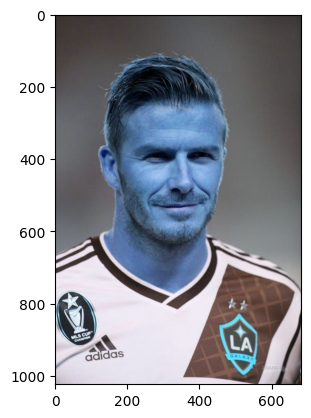

In [18]:
import matplotlib.pyplot as plt
plt.imshow(full_frames[0])

In [20]:
print(tfm_array_list[0])

[array([[ 5.06624421e-01, -5.95483808e-03, -6.05354750e+01],
       [ 5.95483808e-03,  5.06624421e-01, -9.89087747e+01]])]


In [11]:
if use_sr:
    final_frames_list = face_enhancement(final_frames_list, model)

1it [00:01,  1.77s/it]


/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if spsp is not None and isinstance(source_array, spsp.csr.csr_matrix):
[03:41:22] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if spsp is not None and isinstance(source_array, spsp.csr.csr_matrix):


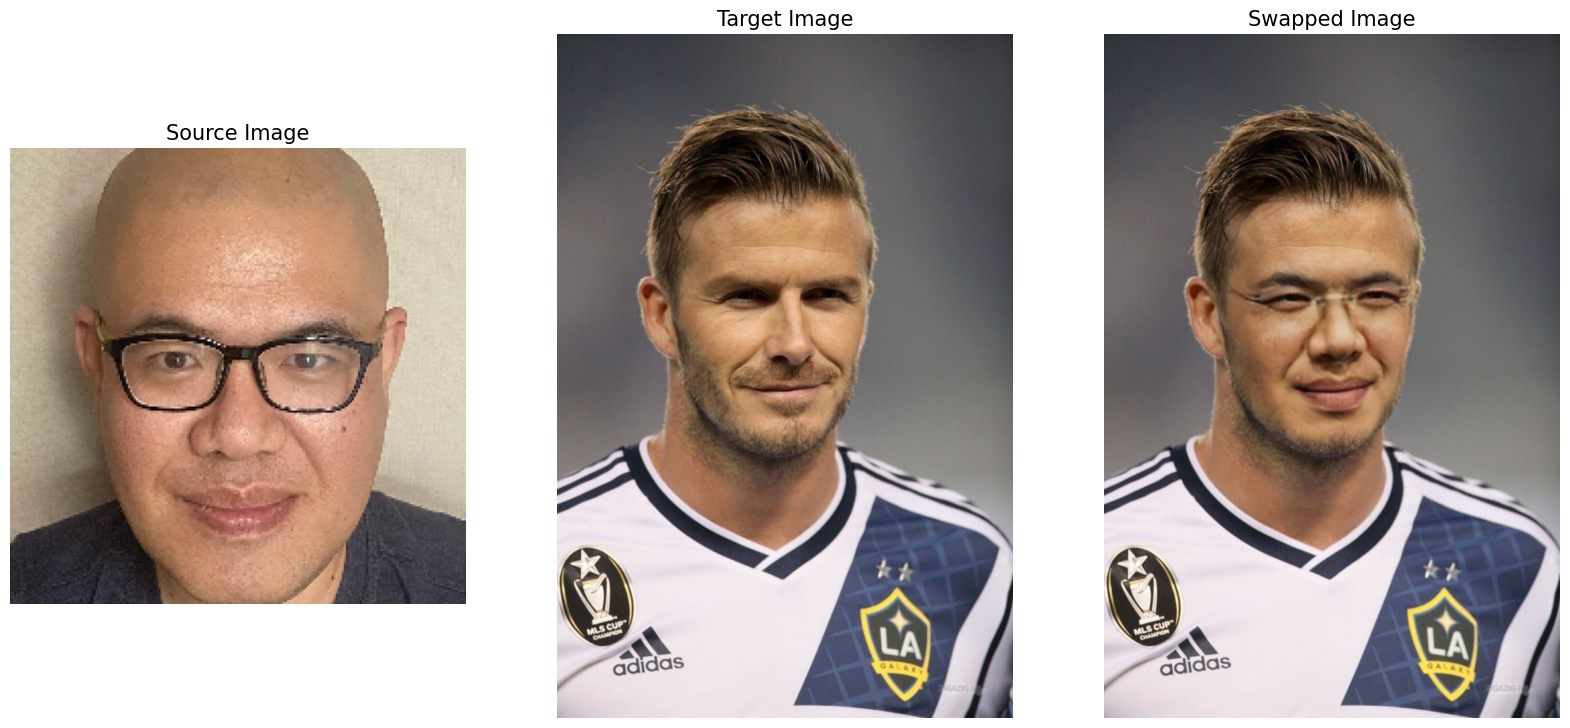

In [12]:
if image_to_image:
    result = get_final_image(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
    show_images([source[0][:, :, ::-1], target_full, result], ['Source Image', 'Target Image', 'Swapped Image'], figsize=(20, 15))
else:
    get_final_video(final_frames_list,
                    crop_frames_list,
                    full_frames,
                    tfm_array_list,
                    OUT_VIDEO_NAME,
                    fps, 
                    handler)
    add_audio_from_another_video(path_to_video, OUT_VIDEO_NAME, "audio")

In [13]:
print(f'Full pipeline took {time.time() - START_TIME}')
if not image_to_image:
    print(f"Video saved with path {OUT_VIDEO_NAME}")

Full pipeline took 4.430737018585205


# Generate fake images

In [ ]:
import warnings
warnings.filterwarnings("ignore")

test_set_path = "examples/images/ff_frames/original"
result_path = "examples/results/ff_frames"

#OUT_VIDEO_NAME = "examples/results/result_tmp.mp4"
crop_size = 224 # don't change this
BS = 60

#test_set_id_folders = glob.glob(test_set_path+"/*")
#test_set_id_folders.sort()
np.random.seed(7777)
for source_id in range(0, 1000):
    num_made = 0
    while num_made < 10:
        target_id = np.random.choice(1000, [1])[0]
        if source_id == target_id:
            continue
        source_candi = glob.glob(f"{test_set_path}/{source_id:03d}_frames/*.jpg")
        source_full = cv2.imread(np.random.choice(source_candi))
        source_full = cv2.copyMakeBorder(source_full, crop_size//2,crop_size//2,crop_size//2,crop_size//2, cv2.BORDER_CONSTANT, (0, 0, 0))
        source_full = cv2.resize(source_full, [crop_size,crop_size])
        target_candi = glob.glob(f"{test_set_path}/{target_id:03d}_frames/*.jpg")
        target_full = cv2.imread(np.random.choice(target_candi))
        target_full = cv2.resize(target_full, [crop_size,crop_size])
        target_full = cv2.copyMakeBorder(target_full, crop_size//2,crop_size//2,crop_size//2,crop_size//2, cv2.BORDER_CONSTANT, (0, 0, 0))
        source = [source_full]

        try:    
            source = crop_face(source_full, app, crop_size)[0]
            source = [source[:, :, ::-1]]
            print("Everything is ok!")
        except TypeError:
            print("Bad source images")
            continue

        full_frames = [target_full]
        target = get_target(full_frames, app, crop_size)
        if type(target) == type(None) or len(target) == 0:
            continue
        #target = full_frames
        final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                        source,
                                                                                        target,
                                                                                        netArc,
                                                                                        G,
                                                                                        app,
                                                                                        set_target = False,
                                                                                        crop_size=crop_size,
                                                                                        BS=BS)
        if use_sr:
            final_frames_list = face_enhancement(final_frames_list, model)
        result = get_final_image(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
        #show_images([source[0][:, :, ::-1], target_full, result], ['Source Image', 'Target Image', 'Swapped Image'], figsize=(20, 15))
        cv2.imwrite(f"{result_path}/{source_id:03d}_{target_id:03d}_{num_made}.jpg", result)
        #assert False
        num_made += 1

# generate fake image from crop

In [7]:
import warnings
warnings.filterwarnings("ignore")

test_set_path = "examples/images/VggFace2-crop"
result_path = "examples/results/VggFace2-crop"
os.makedirs(result_path, exist_ok=True)

#OUT_VIDEO_NAME = "examples/results/result_tmp.mp4"
crop_size = 224 # don't change this
pad_size = crop_size//2
BS = 60

test_set_id_folders = glob.glob(test_set_path+"/*")
test_set_id_folders.sort()
np.random.seed(7777)
for source_path in real_tqdm(test_set_id_folders):
    source_id = source_path.split("n")[-1]
    num_made = 0
    while num_made < 10:
        target_path = np.random.choice(test_set_id_folders)
        target_id = target_path.split("n")[-1]

        if source_path == target_path:
            continue
        source_candi = glob.glob(f"{source_path}/*.jpg") 
        selected_source = np.random.choice(source_candi)
        source_full = cv2.imread(selected_source)
        #source_full = cv2.copyMakeBorder(source_full, crop_size//2,crop_size//2,crop_size//2,crop_size//2, cv2.BORDER_CONSTANT, (0, 0, 0))
        #source_full = cv2.resize(source_full, [crop_size,crop_size])
        target_candi = glob.glob(f"{target_path}/*.jpg")
        selected_target = np.random.choice(target_candi)
        target_full = cv2.imread(selected_target)
        #target_full = cv2.resize(target_full, [crop_size,crop_size])

        target_full = cv2.copyMakeBorder(target_full, pad_size ,pad_size ,pad_size ,pad_size , cv2.BORDER_CONSTANT, (0, 0, 0))
        

        try:    
            #source = crop_face(source_full, app, crop_size)[0]
            #source = [source[:, :, ::-1]]
            source = [source_full]
            #print("Everything is ok!")
        except TypeError:
            print("Bad source images")
            continue

        full_frames = [target_full]
        target = get_target(full_frames, app, crop_size)
        #target =  [target_full]
        if type(target) == type(None) or len(target) == 0:
            print("wat")
            #assert False
            continue
        #target = full_frames
        final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                        source,
                                                                                        target,
                                                                                        netArc,
                                                                                        G,
                                                                                        app,
                                                                                        set_target = False,
                                                                                        crop_size=crop_size,
                                                                                        BS=BS)
        if use_sr:
            final_frames_list = face_enhancement(final_frames_list, model)
        result = get_final_image(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
        #show_images([source[0][:, :, ::-1], target_full, result], ['Source Image', 'Target Image', 'Swapped Image'], figsize=(20, 15))
        cv2.imwrite("{}/src{}_{}_tgt{}_{}.jpg".format(
            result_path,
            source_id,
            os.path.splitext(os.path.basename(selected_source))[0],
            target_id,
            os.path.splitext(os.path.basename(selected_target))[0]
            ), result[pad_size:-pad_size, pad_size:-pad_size])
        #assert False
        num_made += 1

  0%|          | 0/8631 [00:00<?, ?it/s]

  6%|▌         | 482/8631 [44:00<12:21:21,  5.46s/it]

Video doesn't contain face!
wat


  6%|▌         | 509/8631 [46:27<12:12:25,  5.41s/it]

Video doesn't contain face!
wat


  7%|▋         | 593/8631 [54:05<12:05:21,  5.41s/it]

Video doesn't contain face!
wat


  8%|▊         | 700/8631 [1:03:48<11:51:19,  5.38s/it]

Video doesn't contain face!
wat


  8%|▊         | 705/8631 [1:04:15<11:59:16,  5.44s/it]

Video doesn't contain face!
wat


 15%|█▍        | 1258/8631 [1:54:32<11:11:34,  5.47s/it]

Video doesn't contain face!
wat


 18%|█▊        | 1558/8631 [2:21:51<10:40:30,  5.43s/it]

Video doesn't contain face!
wat


 19%|█▊        | 1607/8631 [2:26:19<10:45:35,  5.51s/it]

Video doesn't contain face!
wat


 19%|█▉        | 1669/8631 [2:31:57<10:30:40,  5.44s/it]

Video doesn't contain face!
wat


 24%|██▍       | 2090/8631 [3:10:17<9:56:56,  5.48s/it] 

Video doesn't contain face!
wat


 25%|██▌       | 2184/8631 [3:18:54<9:50:17,  5.49s/it] 

Video doesn't contain face!
wat


 26%|██▌       | 2229/8631 [3:23:02<9:50:09,  5.53s/it] 

Video doesn't contain face!
wat


 29%|██▉       | 2506/8631 [3:48:28<9:22:16,  5.51s/it] 

Video doesn't contain face!
wat


 31%|███       | 2640/8631 [4:00:45<9:06:55,  5.48s/it]

Video doesn't contain face!
wat


 31%|███▏      | 2712/8631 [4:07:20<8:56:58,  5.44s/it]

Video doesn't contain face!
wat


 32%|███▏      | 2756/8631 [4:11:23<9:02:16,  5.54s/it]

Video doesn't contain face!
wat


 35%|███▍      | 3019/8631 [4:35:30<8:32:37,  5.48s/it]

Video doesn't contain face!
wat


 39%|███▉      | 3397/8631 [5:08:15<8:12:38,  5.65s/it]

Video doesn't contain face!
wat


 42%|████▏     | 3661/8631 [5:33:28<7:53:18,  5.71s/it]

Video doesn't contain face!
wat


 43%|████▎     | 3717/8631 [5:38:48<7:46:29,  5.70s/it]

Video doesn't contain face!
wat


 45%|████▌     | 3917/8631 [5:57:55<7:29:04,  5.72s/it]

Video doesn't contain face!
wat


 48%|████▊     | 4116/8631 [6:16:52<7:11:06,  5.73s/it]

Video doesn't contain face!
wat


 51%|█████     | 4400/8631 [6:43:59<6:42:51,  5.71s/it]

Video doesn't contain face!
wat


 55%|█████▍    | 4746/8631 [7:17:00<6:15:11,  5.79s/it]

Video doesn't contain face!
wat


 59%|█████▊    | 5070/8631 [7:47:57<5:40:40,  5.74s/it]

Video doesn't contain face!
wat


 60%|█████▉    | 5152/8631 [7:55:48<5:31:25,  5.72s/it]

Video doesn't contain face!
wat


 63%|██████▎   | 5402/8631 [8:19:38<5:06:56,  5.70s/it]

Video doesn't contain face!
wat


 68%|██████▊   | 5842/8631 [9:01:40<4:28:38,  5.78s/it]

Video doesn't contain face!
wat


 70%|██████▉   | 6033/8631 [9:19:56<4:07:50,  5.72s/it]

Video doesn't contain face!
wat


 70%|██████▉   | 6034/8631 [9:20:02<4:07:56,  5.73s/it]

Video doesn't contain face!
wat


 73%|███████▎  | 6263/8631 [9:41:54<3:46:04,  5.73s/it]

Video doesn't contain face!
wat


 73%|███████▎  | 6285/8631 [9:44:00<3:44:36,  5.74s/it]

Video doesn't contain face!
wat


 76%|███████▌  | 6531/8631 [10:07:30<3:19:43,  5.71s/it]

Video doesn't contain face!
wat


 80%|████████  | 6933/8631 [10:45:53<2:42:26,  5.74s/it]

Video doesn't contain face!
wat


 86%|████████▌ | 7417/8631 [11:32:06<1:55:59,  5.73s/it]

Video doesn't contain face!
wat


 88%|████████▊ | 7621/8631 [11:51:39<1:37:47,  5.81s/it]

Video doesn't contain face!
wat


 89%|████████▊ | 7647/8631 [11:54:08<1:34:25,  5.76s/it]

Video doesn't contain face!
wat


 89%|████████▉ | 7677/8631 [11:57:01<1:31:25,  5.75s/it]

Video doesn't contain face!
wat


 89%|████████▉ | 7685/8631 [11:57:47<1:31:15,  5.79s/it]

Video doesn't contain face!
wat


 89%|████████▉ | 7691/8631 [11:58:22<1:29:51,  5.74s/it]

Video doesn't contain face!
wat


 90%|█████████ | 7800/8631 [12:08:47<1:19:15,  5.72s/it]

Video doesn't contain face!
wat


 92%|█████████▏| 7900/8631 [12:18:19<1:09:53,  5.74s/it]

Video doesn't contain face!
wat


 93%|█████████▎| 7985/8631 [12:26:27<1:01:33,  5.72s/it]

Video doesn't contain face!
wat


 94%|█████████▎| 8076/8631 [12:35:09<53:36,  5.80s/it]  

Video doesn't contain face!
wat


 94%|█████████▍| 8150/8631 [12:42:15<46:06,  5.75s/it]

Video doesn't contain face!
wat


 95%|█████████▌| 8216/8631 [12:48:34<39:54,  5.77s/it]

Video doesn't contain face!
wat


 98%|█████████▊| 8496/8631 [13:15:23<12:59,  5.77s/it]

Video doesn't contain face!
wat


100%|██████████| 8631/8631 [13:28:22<00:00,  5.62s/it]


'examples/results/VggFace2-crop/src003664_0185_01_tgt001469_0175_02_4.jpg'

In [3]:
import warnings
warnings.filterwarnings("ignore")

test_set_path = "examples/images/VggFace2-crop"
result_path = "examples/results/VggFace2-crop"

#OUT_VIDEO_NAME = "examples/results/result_tmp.mp4"
crop_size = 224 # don't change this
BS = 60

test_set_id_folders = glob.glob(test_set_path+"/*")
test_set_id_folders.sort()
with open("VggFace2-crop_src_tgt.txt", "w") as log_file:
    np.random.seed(7777)
    for source_path in real_tqdm(test_set_id_folders):
        source_id = source_path.split("n")[-1]
        num_made = 0
        while num_made < 10:
            target_path = np.random.choice(test_set_id_folders)
            target_id = target_path.split("n")[-1]

            if source_path == target_path:
                continue
            source_candi = glob.glob(f"{source_path}/*.jpg") 
            selected_source = np.random.choice(source_candi)
            source_full = cv2.imread(selected_source)
            #source_full = cv2.copyMakeBorder(source_full, crop_size//2,crop_size//2,crop_size//2,crop_size//2, cv2.BORDER_CONSTANT, (0, 0, 0))
            #source_full = cv2.resize(source_full, [crop_size,crop_size])
            target_candi = glob.glob(f"{target_path}/*.jpg")
            selected_target = np.random.choice(target_candi)
            target_full = cv2.imread(selected_target)
            #target_full = cv2.resize(target_full, [crop_size,crop_size])

            target_full = cv2.copyMakeBorder(target_full, crop_size//4,crop_size//4,crop_size//4,crop_size//4, cv2.BORDER_CONSTANT, (0, 0, 0))
            

            try:    
                #source = crop_face(source_full, app, crop_size)[0]
                #source = [source[:, :, ::-1]]
                source = [source_full]
                #print("Everything is ok!")
            except TypeError:
                print("Bad source images")
                continue

            full_frames = [target_full]
            target = get_target(full_frames, app, crop_size)
            #target =  [target_full]
            if type(target) == type(None) or len(target) == 0:
                print("wat")
                #assert False
                continue

            log_file.write(f"{selected_source} {selected_target}\n")
            #cv2.imwrite(f"{result_path}/{source_id}_{target_id}_{num_made}.jpg", result[crop_size//4:-crop_size//4, crop_size//4:-crop_size//4])
            #assert False
            num_made += 1

  0%|          | 0/8631 [00:00<?, ?it/s]

  0%|          | 7/8631 [00:02<29:10,  4.93it/s]  

Video doesn't contain face!
wat


  1%|          | 102/8631 [00:14<18:44,  7.58it/s]

Video doesn't contain face!
wat


  2%|▏         | 205/8631 [00:28<18:26,  7.61it/s]

Video doesn't contain face!
wat


  4%|▎         | 318/8631 [00:42<17:54,  7.74it/s]

Video doesn't contain face!
wat


  4%|▍         | 365/8631 [00:49<17:48,  7.74it/s]

Video doesn't contain face!
wat


  5%|▍         | 409/8631 [00:54<17:49,  7.69it/s]

Video doesn't contain face!
wat


  5%|▌         | 463/8631 [01:01<17:41,  7.70it/s]

Video doesn't contain face!
wat


  6%|▌         | 484/8631 [01:04<17:22,  7.81it/s]

Video doesn't contain face!
wat


  6%|▌         | 511/8631 [01:07<17:26,  7.76it/s]

Video doesn't contain face!
wat


  7%|▋         | 565/8631 [01:14<17:17,  7.77it/s]

Video doesn't contain face!
wat


  7%|▋         | 595/8631 [01:18<17:17,  7.74it/s]

Video doesn't contain face!
wat


  7%|▋         | 602/8631 [01:19<17:38,  7.58it/s]

Video doesn't contain face!
wat


  8%|▊         | 702/8631 [01:32<17:25,  7.58it/s]

Video doesn't contain face!
wat


  8%|▊         | 706/8631 [01:33<17:34,  7.51it/s]

Video doesn't contain face!
wat


 10%|▉         | 854/8631 [01:52<21:42,  5.97it/s]

Video doesn't contain face!
wat


 10%|█         | 898/8631 [01:58<16:31,  7.80it/s]

Video doesn't contain face!
wat


 11%|█         | 924/8631 [02:01<19:45,  6.50it/s]

Video doesn't contain face!
wat


 11%|█         | 942/8631 [02:04<16:37,  7.71it/s]

Video doesn't contain face!
wat


 13%|█▎        | 1079/8631 [02:21<16:18,  7.72it/s]

Video doesn't contain face!
wat


 13%|█▎        | 1103/8631 [02:24<16:10,  7.76it/s]

Video doesn't contain face!
wat


 14%|█▍        | 1237/8631 [02:41<16:01,  7.69it/s]

Video doesn't contain face!
wat


 15%|█▍        | 1260/8631 [02:44<15:47,  7.78it/s]

Video doesn't contain face!
wat


 18%|█▊        | 1560/8631 [03:22<15:16,  7.72it/s]

Video doesn't contain face!
wat


 18%|█▊        | 1586/8631 [03:25<15:17,  7.68it/s]

Video doesn't contain face!
wat


 19%|█▊        | 1608/8631 [03:28<15:14,  7.68it/s]

Video doesn't contain face!
wat


 19%|█▊        | 1613/8631 [03:29<15:09,  7.71it/s]

Video doesn't contain face!
wat


 19%|█▉        | 1646/8631 [03:33<15:10,  7.67it/s]

Video doesn't contain face!
wat


 19%|█▉        | 1648/8631 [03:33<16:34,  7.02it/s]

Video doesn't contain face!
wat


 19%|█▉        | 1670/8631 [03:36<15:26,  7.51it/s]

Video doesn't contain face!
wat


 20%|█▉        | 1689/8631 [03:39<14:58,  7.72it/s]

Video doesn't contain face!
wat


 20%|██        | 1758/8631 [03:48<15:03,  7.60it/s]

Video doesn't contain face!
wat


 21%|██        | 1796/8631 [03:53<14:55,  7.63it/s]

Video doesn't contain face!
wat


 21%|██        | 1815/8631 [03:55<14:35,  7.79it/s]

Video doesn't contain face!
wat


 23%|██▎       | 1988/8631 [04:17<14:37,  7.57it/s]

Video doesn't contain face!
wat


 23%|██▎       | 1998/8631 [04:18<14:18,  7.72it/s]

Video doesn't contain face!
wat


 24%|██▍       | 2092/8631 [04:31<13:54,  7.84it/s]

Video doesn't contain face!
wat


 25%|██▍       | 2135/8631 [04:36<14:01,  7.72it/s]

Video doesn't contain face!
wat


 25%|██▍       | 2156/8631 [04:39<13:54,  7.76it/s]

Video doesn't contain face!
wat


 25%|██▌       | 2182/8631 [04:42<13:54,  7.73it/s]

Video doesn't contain face!
wat


 25%|██▌       | 2185/8631 [04:43<13:57,  7.70it/s]

Video doesn't contain face!
wat


 26%|██▌       | 2230/8631 [04:48<13:42,  7.78it/s]

Video doesn't contain face!
wat


 27%|██▋       | 2304/8631 [04:58<13:40,  7.71it/s]

Video doesn't contain face!
wat


 28%|██▊       | 2389/8631 [05:08<13:22,  7.78it/s]

Video doesn't contain face!
wat


 28%|██▊       | 2452/8631 [05:16<13:16,  7.76it/s]

Video doesn't contain face!
wat


 29%|██▉       | 2502/8631 [05:23<16:58,  6.02it/s]

Video doesn't contain face!
wat
Video doesn't contain face!
wat


 29%|██▉       | 2507/8631 [05:24<14:31,  7.02it/s]

Video doesn't contain face!
wat


 30%|██▉       | 2565/8631 [05:31<13:04,  7.74it/s]

Video doesn't contain face!
wat


 31%|███       | 2641/8631 [05:40<12:52,  7.75it/s]

Video doesn't contain face!
wat


 31%|███▏      | 2712/8631 [05:49<13:01,  7.57it/s]

Video doesn't contain face!
wat
Video doesn't contain face!
wat


 32%|███▏      | 2730/8631 [05:52<12:36,  7.80it/s]

Video doesn't contain face!
wat


 32%|███▏      | 2740/8631 [05:53<12:35,  7.79it/s]

Video doesn't contain face!
wat


 32%|███▏      | 2765/8631 [05:56<12:37,  7.75it/s]

Video doesn't contain face!
wat


 34%|███▍      | 2940/8631 [06:19<12:17,  7.71it/s]

Video doesn't contain face!
wat


 34%|███▍      | 2942/8631 [06:19<12:26,  7.62it/s]

Video doesn't contain face!
wat


 35%|███▍      | 2988/8631 [06:25<12:10,  7.73it/s]

Video doesn't contain face!
wat


 35%|███▍      | 3006/8631 [06:27<12:13,  7.67it/s]

Video doesn't contain face!
wat


 35%|███▌      | 3021/8631 [06:29<12:05,  7.73it/s]

Video doesn't contain face!
wat


 37%|███▋      | 3181/8631 [06:50<11:52,  7.65it/s]

Video doesn't contain face!
wat


 37%|███▋      | 3206/8631 [06:53<11:53,  7.60it/s]

Video doesn't contain face!
wat


 37%|███▋      | 3236/8631 [06:57<11:40,  7.70it/s]

Video doesn't contain face!
wat


 38%|███▊      | 3256/8631 [07:00<11:53,  7.53it/s]

Video doesn't contain face!
wat


 38%|███▊      | 3280/8631 [07:03<11:45,  7.59it/s]

Video doesn't contain face!
wat


 38%|███▊      | 3310/8631 [07:07<12:40,  6.99it/s]

Video doesn't contain face!
wat


 39%|███▊      | 3344/8631 [07:11<11:13,  7.85it/s]

Video doesn't contain face!
wat


 39%|███▉      | 3370/8631 [07:14<11:13,  7.81it/s]

Video doesn't contain face!
wat


 39%|███▉      | 3396/8631 [07:18<11:20,  7.69it/s]

Video doesn't contain face!
wat


 40%|███▉      | 3421/8631 [07:21<11:12,  7.75it/s]


KeyboardInterrupt: 